# Example 1: A simple example for OBS

In this example we generate plane wave seismograms and P receiver functions for an ocean-bottom seismic stations. This example follows that of Figure 2 in [Audet (2016)](#references). 

Start by importing the necessary modules

In [1]:
from obspy.core import Stream
from obspy.signal.rotate import rotate_ne_rt
from telewavesim import utils as ut
from telewavesim import wiggle as wg

Select the model file:

In [2]:
modfile = '../models/model_Audet2016.txt'

Select the type of incident wave - options are `'P'`, `'SV'`, `'SH'`, or `'Si'`, which is an isotropic S-wave source:

In [3]:
wvtype = 'P'

Next we use global variables to define the desired time series. Be careful to use a total length of time large enough to avoid wrap around effects. Sometimes if you see signals arriving at aberrant times, try with either a greater number of samples or higher `dt`.

In [4]:
npts = 3000 # Number of samples
dt = 0.01   # Sample distance in seconds

Here we choose to model seismograms for an ocean-bottom station, so we specify the deployment depth. 

<p class="alert alert-warning">
  <strong>Warning!</strong> This one is required for OBS simulations. Otherwise an Exception will be raised and the code will stop.
</p>

In [5]:
dp = 2000. # Deployment depth below sea level in meters

The parameters (P-wave velocity and density) of the water layer have default values of 1500 m/s and 1027 kg/m^3, respectively, but these values can be changed here:

In [6]:
c = 1.5      # P-wave velocity in salt water (km/s)
rhof = 1027. # Density of salt water (kg/m^3)

Now specify the parameters of the incident wavefield in terms of a horizontal slowness and back-azimuth.

In [7]:
slow = 0.06 # Horizontal slowness (or ray parameter) in s/km 
baz = 0.    # Back-azimuth direction in degrees (has no influence if model is isotropic)

Read the model parameters from the model file and return a Model object. Up to here, the steps could have been performed in no particular order, except the name of the file that needs to be defined before the call to `read_model()`.

In [8]:
model = ut.read_model(modfile)
print(list(model.rho))

[2800.0, 2800.0, 3200.0]


The following step is useful for plotting the seismograms with respect to the predicted propagation time through the model (from lowermost interface up to the seafloor). 

In [9]:
t1 = ut.calc_ttime(model, slow, wvtype=wvtype)
print('Predicted propagation time from model: {0:4.1f} sec'.format(t1))

Predicted propagation time from model:  1.1 sec


Here we generate the plane wave seismograms by calling the `plane` module from the `utils` module and storing the output in a 3-component stream oriented in North, East and Vertical directions. This is also where we specify that we are interested in OBS synthetic data, i.e., including effects from an overlying water layer. The `obs` boolean variable defaults to `False`, so use the following call with argument `obs=True`.

<p class="alert alert-info">This one line below is the main time-consuming part of the code!</p>

In [10]:
trxyz = ut.run_plane(model, slow, npts, dt, baz=baz, wvtype=wvtype,
                     obs=True, dp=dp, c=c, rhof=rhof)

We could also calculate the transfer functions between components - here since the incident wave is a P-wave, we can get the radial and transverse transfer functions as an `obspy` `Stream` object. The option `pvh=False` tells the code to use the regular Z-R-T geometry. The option `pvh=True` rotates the components to the P-SV-SH wave modes using the seismic velocity of the topmost solid layer. 

In [11]:
tfs = ut.tf_from_xyz(trxyz, pvh=False)

Here we can extract individual components as `obspy` `Traces` and rotate them to the Radial and Transverse directions

In [12]:
ntr = trxyz[0] # North component
etr = trxyz[1] # East component
ztr = trxyz[2] # Vertical component

# Copy to radial and transverse
rtr = ntr.copy() # Radial component
ttr = etr.copy() # Transverse component

# Rotate to radial and transverse
rtr.data, ttr.data = rotate_ne_rt(ntr.data, etr.data, baz)

For plotting purposes, we create a new `obspy` `Stream` object that includes one transfer function and two Green's functions

In [13]:
strf = Stream(traces=[tfs[0],ztr,rtr])

Now plot the result as wiggles, using the format displayed in the paper by Audet (GJI, 2016). First you will have to define frequency corners (defaults are `f1 = 0.1` and `f2 = 1.0` for `'P'` wavetype).

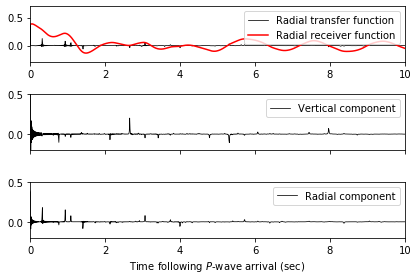

In [14]:
# Set frequency corners in Hz
f1 = 0.1
f2 = 1.0

# Plot as wiggles
wg.pw_wiggles_Audet2016(strf, t1=t1, tmax=10., f1=f1, f2=f2,
                        ftitle='audet2016', scale=2.e-7, save=False)

Voilà! 

You can play with these parameters and change the model file (while respecting its format) and see how the seismograms change. You can also compare the run time difference between the Python and Fortran implementations, but for this simple case with only one plane wave simulation, the difference is minor.

## References
* Audet, P. (2016). Receiver functions using OBS data: promises and limitations from numerical modelling and examples from the Cascadia Initiative. Geophysical Journal International, 205, 1740-1755. https://doi.org/10.1093/gji/ggw111